# Import

In [1]:
# -*- coding: utf-8 -*-
import random
import pylab
from statistics import stdev 
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc


# Function

## get data

In [2]:
def getDF(filename):
    df = pd.read_table(filename, sep=',')
    df.reset_index(inplace=True)
    df.drop(["'survived'", "'name'"], axis=1, inplace=True)
    df.columns = ['cabin', 'age', 'gender', 'survived']
    df['gender'].replace(['F', 'M'], [0, 1], inplace=True)
    return df


In [3]:
def getData(filename):
    df = getDF(filename)
    data = {}
    df_label = list(df.columns)
    for x in df_label:
        data[x] = df.loc[:, x].to_list()
    return data
    

In [4]:
def makeHist(data, data_label=None, bins=20, title='', xLabel='', yLabel='', islegend=True):
    mean, std = [], []
    data_len = len(data)
    if data_label == None:
        data_label = []
        for i in range(data_len):
            data_label.append('')
    for d in data:
        mean.append(sum(d)/len(d))
        std.append(stdev(d))
    pylab.figure(facecolor='white', figsize=(12, 9))
    for i in range(data_len):
        pylab.hist(data[i], bins, ec='black', 
                   label=data_label[i]+'\nMean = '+str(round(mean[i], 2)) +'  SD = ' + str(round(std[i], 2))) 
    pylab.title(title, fontsize=20) 
    pylab.xlabel(xLabel, fontsize=16) 
    pylab.ylabel(yLabel, fontsize=16) 
    if islegend == True:
        pylab.legend(fontsize=16)
    pylab.show()


In [5]:
def buildExamples(fileName): 
    data = getData(fileName)
    examples = [] 
    for i in range(len(data['age'])): 
        a = Passenger(data['cabin'][i], data['age'][i], data['gender'][i], data['survived'][i]) 
        examples.append(a)
    return examples 


In [6]:
def divide80_20(examples): 
    sampleIndices = random.sample(range(len(examples)), len(examples)//5) 
    trainingSet, testSet = [], [] 
    for i in range(len(examples)): 
        if i in sampleIndices: 
            testSet.append(examples[i]) 
        else: trainingSet.append(examples[i]) 
    return trainingSet, testSet 


In [7]:
def zScaleFeatures(vals): 
    """Assumes vals is a sequence of floats""" 
    result = pylab.array(vals) 
    mean = sum(result)/len(result) 
    result = result - mean 
    return result/stdev(result) 


In [8]:
def iScaleFeatures(vals): 
    """Assumes vals is a sequence of floats""" 
    minVal, maxVal = min(vals), max(vals) 
    fit = pylab.polyfit([minVal, maxVal], [0, 1], 1) 
    return pylab.polyval(fit, vals) 
    

## class

In [9]:
def minkowskiDist(v1, v2, p):
    """Assumes v1 and v2 are equal-length arrays of numbers
       Returns Minkowski distance of order p between v1 and v2"""
    dist = 0.0
    for i in range(len(v1)):
        dist += abs(v1[i] - v2[i])**p
    return dist**(1/p)


In [10]:
class Passenger(object):
    featureNames = ('C1', 'C2', 'C3', 'age', 'male gender')
    def __init__(self, pClass, age, gender, survived):
        if pClass == 1:
            self.featureVec = [1, 0, 0, age, gender]
        elif pClass == 2:
            self.featureVec = [0, 1, 0, age, gender]
        else:
            self.featureVec = [0, 0, 1, age, gender]
        self.label = survived
        self.cabinClass = pClass
    def distance(self, other):
        return minkowskiDist(self.featureVec, other.featureVec, 2)
    def getClass(self):
        return self.cabinClass
    def getAge(self):
        return self.featureVec[3]
    def getGender(self):
        return self.featureVec[4]
    def getName(self):
        return self.name
    def getFeatures(self):
        return self.featureVec[:]
    def getLabel(self):
        return self.label


## Statistic

In [11]:
def accuracy(truePos, falsePos, trueNeg, falseNeg): 
    numerator = truePos + trueNeg 
    denominator = truePos + trueNeg + falsePos + falseNeg 
    return numerator/denominator 
    

In [12]:
def sensitivity(truePos, falseNeg): 
    try: 
        return truePos/(truePos + falseNeg) 
    except ZeroDivisionError: 
        return float('nan') 
        

In [13]:
def specificity(trueNeg, falsePos): 
    try: 
        return trueNeg/(trueNeg + falsePos) 
    except ZeroDivisionError: 
        return float('nan') 


In [14]:
def posPredVal(truePos, falsePos): 
    try:
        return truePos/(truePos + falsePos) 
    except ZeroDivisionError: 
        return float('nan') 
        

In [15]:
def negPredVal(trueNeg, falseNeg): 
    try: 
        return trueNeg/(trueNeg + falseNeg) 
    except ZeroDivisionError: 
        return float('nan')
        

In [16]:
def getStats(truePos, falsePos, trueNeg, falseNeg, toPrint = True): 
    accur = accuracy(truePos, falsePos, trueNeg, falseNeg) 
    sens = sensitivity(truePos, falseNeg) 
    spec = specificity(trueNeg, falsePos) 
    ppv = posPredVal(truePos, falsePos) 
    if toPrint: 
        print(' Accuracy =', round(accur, 3)) 
        print(' Sensitivity =', round(sens, 3)) 
        print(' Specificity =', round(spec, 3)) 
        print(' Pos. Pred. Val. =', round(ppv, 3)) 
    return (accur, sens, spec, ppv) 
    

## Logistic

In [17]:
def applyModel(model, testSet, label, prob = 0.5):
    #Create vector containing feature vectors for all test examples
    testFeatureVecs = [e.getFeatures() for e in testSet]
    probs = model.predict_proba(testFeatureVecs)
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for i in range(len(probs)):
        if probs[i][1] > prob:
            if testSet[i].getLabel() == label:
                truePos += 1
            else:
                falsePos += 1
        else:
            if testSet[i].getLabel() != label:
                trueNeg += 1
            else:
                falseNeg += 1
    return truePos, falsePos, trueNeg, falseNeg


In [18]:
def buildROC(model, testSet, label, title='', plot=True):
    xVals, yVals = [], []
    p = 0.0
    while p <= 1.0:
        truePos, falsePos, trueNeg, falseNeg = applyModel(model, testSet, label, p)
        xVals.append(1.0 - specificity(trueNeg, falsePos))
        yVals.append(sensitivity(truePos, falseNeg))
        p += 0.01
    auroc = auc(xVals, yVals)
    if plot:
        pylab.figure()
        pylab.plot(xVals, yVals)
        pylab.plot([0,1], [0,1,], '--')
        pylab.title(title +  ' (AUROC = ' + str(round(auroc, 3)) + ')')
        pylab.xlabel('1 - Specificity - False Postitive Rate')
        pylab.ylabel('Sensitivity-True Positive Rate')
    return auroc


In [19]:
def testModel(examples, numTrials, title1=None, title2=None, printWeights=True, printStats=True):
    stats, weights = [], [[], [], [], [], []]
    ks, k_accu, klist, klistmean, kx = [], [], [], [], []
    maxmeanacc, maxacck = 0, 0
    for i in range(201):
        klist.append([])
    for i in range(numTrials):
        training, testSet = divide80_20(examples)
        x_train, y_train = [], []
        for e in training:
            x_train.append(e.getFeatures())
            y_train.append(e.getLabel())
        x_train = pylab.array(x_train)
        y_train = pylab.array(y_train)
        model = LogisticRegression().fit(x_train, y_train)
        for i in range(len(Passenger.featureNames)):
            weights[i].append(model.coef_[0][i])
        
        max_accu, maxk = 0, 0
        for k in range(400, 601):
            truePos, falsePos, truePos, falseNeg = applyModel(model, testSet, 1, k/1000)
            tmp = getStats(truePos, falsePos, truePos, falseNeg, toPrint=False)
            klist[k-400].append(tmp[0])
            if max_accu < tmp[0]:
                max_accu = tmp[0]
                maxk = k/1000
        ks.append(maxk)
        k_accu.append(max_accu)

        truePos, falsePos, truePos, falseNeg = applyModel(model, testSet, 1, 0.5)
        auroc = buildROC(model, testSet, 1, plot=False)
        tmp = getStats(truePos, falsePos, truePos, falseNeg, toPrint=False)
        stats.append(tmp + (auroc, ))

    makeHist([k_accu, ], ['Maximum Accuracies', ], 
             title='Maximum Accuracies', xLabel='Maximum Accuracies', 
             yLabel='Numbers of Maximum Accuracies', islegend=True)
    makeHist([ks, ], ['k Values for Maximum Accuracies', ], 
             title='Threshold values k for Maximum Accruacies', 
             xLabel='Threshold Values k', yLabel='Numbers of ks', islegend=True)

    for i in range(201):
        t = np.array(klist[i])
        kx.append(0.4+i/1000)
        tm = np.mean(t)
        klistmean.append(tm)
        if maxmeanacc < tm:
            maxmeanacc = tm
            maxacck = 0.4 + i/1000

    pylab.figure(facecolor='white', figsize=(12, 9))
    pylab.title('Mean Accuracies for Different Threshold values', fontsize=20)
    pylab.plot(np.linspace(400, 600, 201)/1000, klistmean, label='Mean Accuracies')
    pylab.plot(maxacck, maxmeanacc, 'ro', label='Maximum Mean Accuracy')
    pylab.xlabel('Thresholds Value k', fontsize=16)
    pylab.ylabel('Accuracy', fontsize=16)
    pylab.annotate((round(maxacck, 3), round(maxmeanacc, 3)), xy=(maxacck+0.005, maxmeanacc+0.0005))
    pylab.legend(fontsize=16)
    pylab.show()

    if printWeights:
        if title1 != None:
            print(title1)
        if title2 != None:
            print(title2)
        for k in range(len(weights)):
            featureMean = sum(weights[k])/numTrials
            featureStd = stdev(weights[k])
            print(' Mean weight of ', Passenger.featureNames[k], 
                  ' = ', round(featureMean, 3),  
                  ', 95% confidence interval = ', round(1.96*featureStd, 3), sep='')
    if printStats:
        stats = np.array(stats)
        meanaccu = sum(stats[:, 0])/numTrials
        meansens = sum(stats[:, 1])/numTrials
        meanspec = sum(stats[:, 2])/numTrials
        meanppv = sum(stats[:, 3])/numTrials
        meanauroc = sum(stats[:, 4])/numTrials
        stdaccu = stdev(stats[:, 0])
        stdsens = stdev(stats[:, 1])
        stdspec = stdev(stats[:, 2])
        stdppv = stdev(stats[:, 3])
        stdauroc = stdev(stats[:, 4])
        print(' Mean accuracy = ', round(meanaccu, 3), 
              ', 95% confidence interval = ', round(1.96*stdaccu, 3), sep='')
        print(' Mean sensitivity = ', round(meansens, 3), 
              ', 95% confidence interval = ', round(1.96*stdsens, 3), sep='')
        print(' Mean specificity = ', round(meanspec, 3), 
              ', 95% confidence interval = ', round(1.96*stdspec, 3), sep='')
        print(' Mean pos. pred. val. = ', round(meanppv, 3), 
              ', 95% confidence interval = ', round(1.96*stdppv, 3), sep='')
        print(' Mean AUROC = ', round(meanauroc, 3), 
              ', 95% confidence interval = ', round(1.96*stdauroc, 3), sep='')


## kNN

In [20]:
def findKNearest(example, exampleSet, k): 
    kNearest, distances = [], [] 
    #Build lists containing first k examples and their distances 
    for i in range(k): 
        kNearest.append(exampleSet[i]) 
        distances.append(example.distance(exampleSet[i])) 
    maxDist = max(distances) #Get maximum distance 
    #Look at examples not yet considered 
    for e in exampleSet[k:]: 
        dist = example.distance(e) 
        if dist < maxDist: 
            #replace farther neighbor by this one 
            maxIndex = distances.index(maxDist) 
            kNearest[maxIndex] = e 
            distances[maxIndex] = dist 
            maxDist = max(distances)
    '''print('\nK nearest:', )
    for i in range(k):
        print(i, ' ', kNearest[i])    
    print('\nTheir Distances', distances)'''
    
    return kNearest, distances 


In [21]:
def KNearestClassify(training, testSet, label, k): 
    """Assumes training and testSet lists of examples, 
    k an int Uses a k-nearest neighbor classifier to 
    predict whether each example in testSet has the given label 
    Returns number of true positives, false positives, true negatives, 
    and false negatives""" 
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0 
    for e in testSet: 
        nearest, distances = findKNearest(e, training, k) 
        #conduct vote 
        numMatch = 0 
        for i in range(len(nearest)): 
            if nearest[i].getLabel() == label: 
                numMatch += 1 
        if numMatch > k//2: #guess label 
            if e.getLabel() == label:
                truePos += 1 
            else: 
                falsePos += 1 
        else: #guess not label 
            if e.getLabel() != label: 
                trueNeg += 1 
            else: 
                falseNeg += 1 
    return truePos, falsePos, trueNeg, falseNeg 


In [22]:
def findK(training, minK, maxK, numFolds, label): 
    #Find average accuracy for range of odd values of k 
    accuracies = [] 
    k_max_acc = -1
    max_acc = 0
    for k in range(minK, maxK+1): 
        score = 0.0 
        for i in range(numFolds): #downsample to reduce computation time
            fold = random.sample(training, min(5000, len(training))) 
            examples, testSet = divide80_20(fold) 
            truePos, falsePos, trueNeg, falseNeg = KNearestClassify(examples, testSet, label, k) 
            score += accuracy(truePos, falsePos, trueNeg, falseNeg) 
        acc = score/numFolds
        accuracies.append(acc) 
        if acc > max_acc:
            max_acc = acc
            k_max_acc = k
    return accuracies, k_max_acc, max_acc
    

# Main

## Part 1, 2

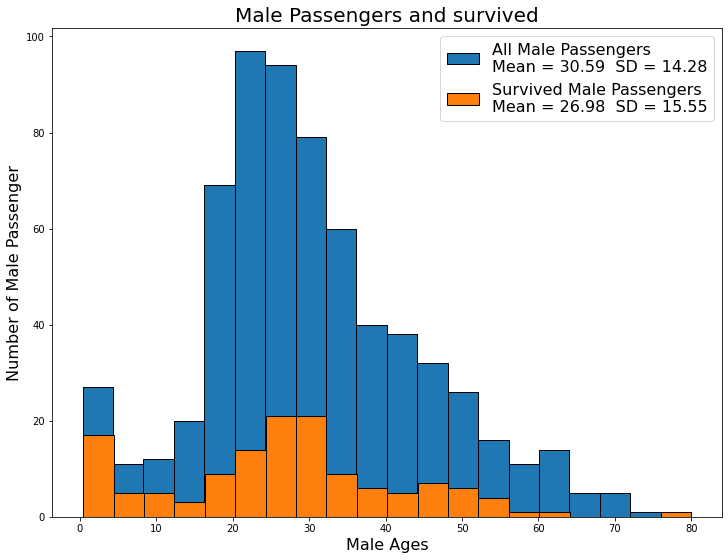

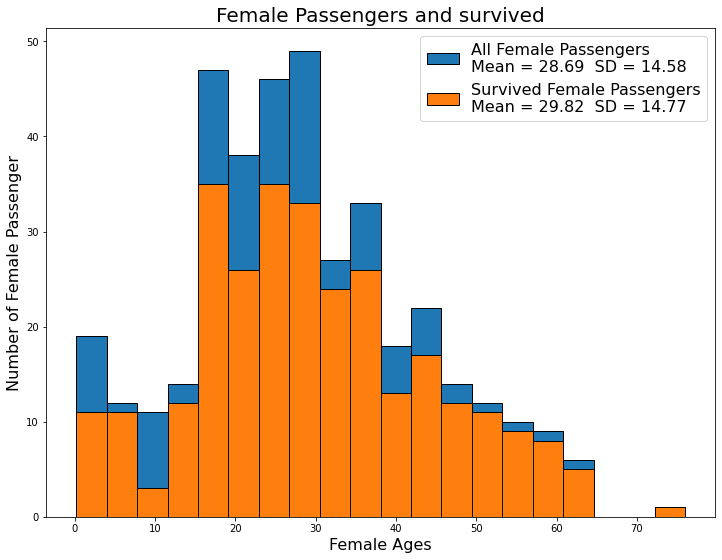

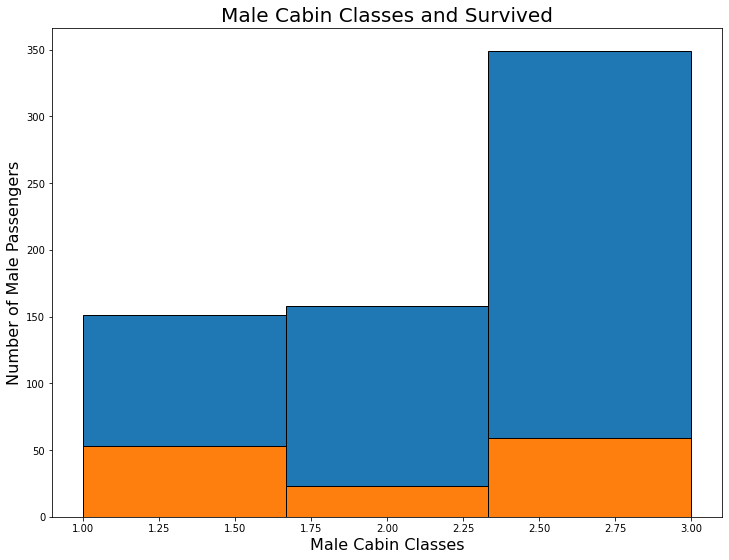

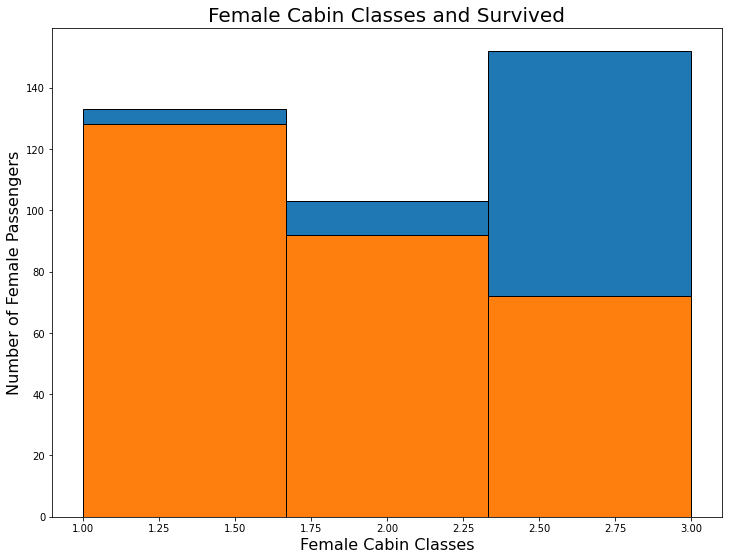

In [23]:
titanic_df = getDF('TitanicPassengers.txt')
male_filter = titanic_df['gender']==1
male_df = titanic_df[male_filter]
female_df = titanic_df[~male_filter]
survive_filter = male_df['survived']==1
survive_male = male_df[survive_filter]
survive_filter = female_df['survived']==1
survive_female = female_df[survive_filter]
makeHist([male_df['age'], survive_male['age']], 
         ['All Male Passengers', 'Survived Male Passengers'], 
         title='Male Passengers and survived', 
         xLabel='Male Ages', yLabel='Number of Male Passenger')
makeHist([female_df['age'], survive_female['age']], 
         ['All Female Passengers', 'Survived Female Passengers'], 
         title='Female Passengers and survived', 
         xLabel='Female Ages', yLabel='Number of Female Passenger')
makeHist([male_df['cabin'], survive_male['cabin']],
         bins=3, title='Male Cabin Classes and Survived', 
         xLabel='Male Cabin Classes', yLabel='Number of Male Passengers', islegend=False)
makeHist([female_df['cabin'], survive_female['cabin']], 
         bins=3, title='Female Cabin Classes and Survived', 
         xLabel='Female Cabin Classes', yLabel='Number of Female Passengers', islegend=False)


## Part3, 4, 5

### Part 3

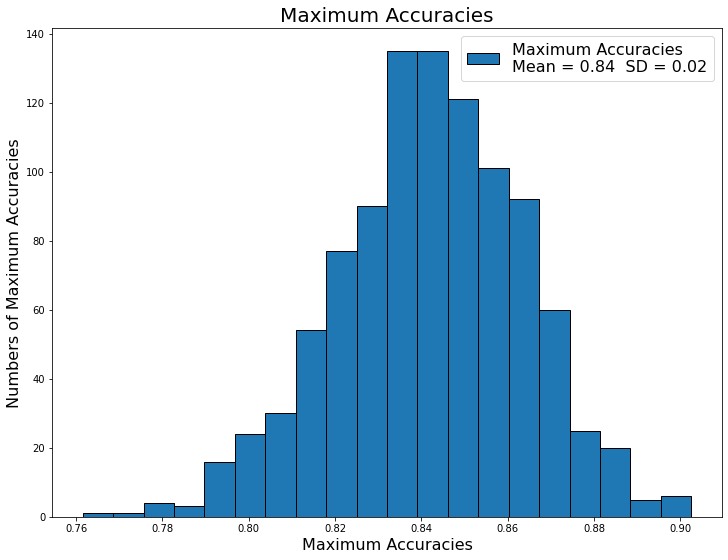

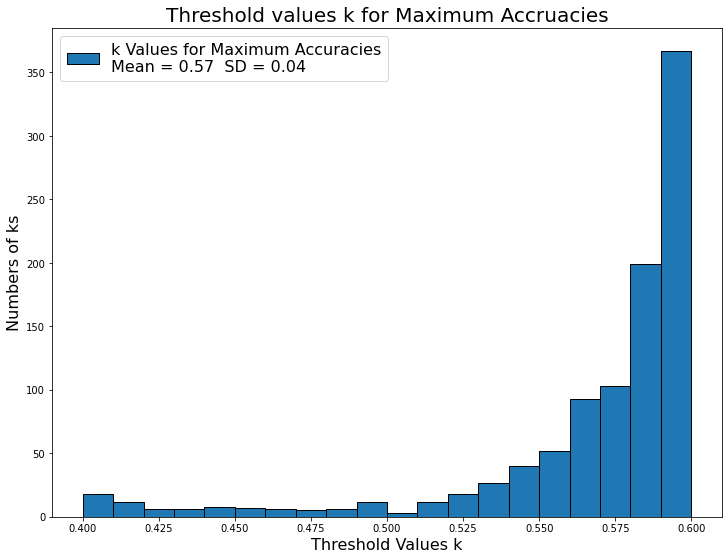

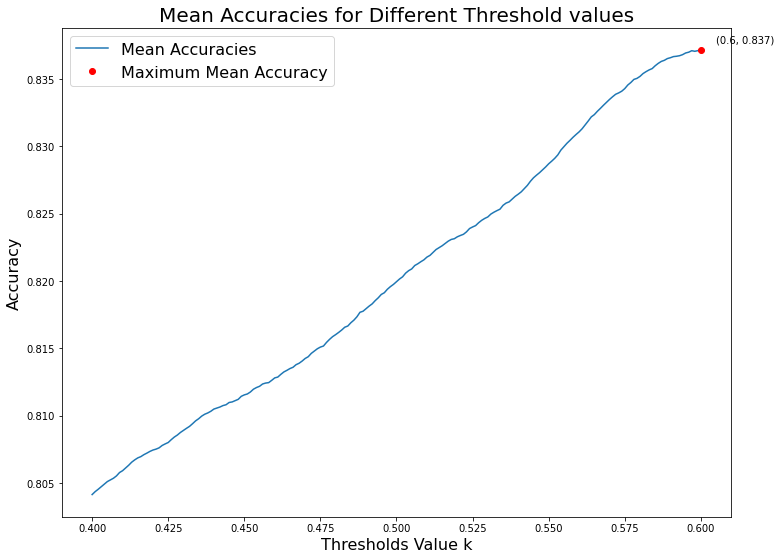

Logistic Regression:
Averages for all examples 1000 trials with k=0.5
 Mean weight of C1 = 1.137, 95% confidence interval = 0.119
 Mean weight of C2 = -0.082, 95% confidence interval = 0.098
 Mean weight of C3 = -1.055, 95% confidence interval = 0.119
 Mean weight of age = -0.033, 95% confidence interval = 0.006
 Mean weight of male gender = -2.408, 95% confidence interval = 0.152
 Mean accuracy = 0.82, 95% confidence interval = 0.046
 Mean sensitivity = 0.804, 95% confidence interval = 0.066
 Mean specificity = 0.838, 95% confidence interval = 0.067
 Mean pos. pred. val. = 0.838, 95% confidence interval = 0.067
 Mean AUROC = 0.839, 95% confidence interval = 0.054


In [24]:
examples = buildExamples('TitanicPassengers.txt')
testModel(examples, 1000, title1='Logistic Regression:', 
          title2='Averages for all examples 1000 trials with k=0.5')
print('='*100)


### Part 4

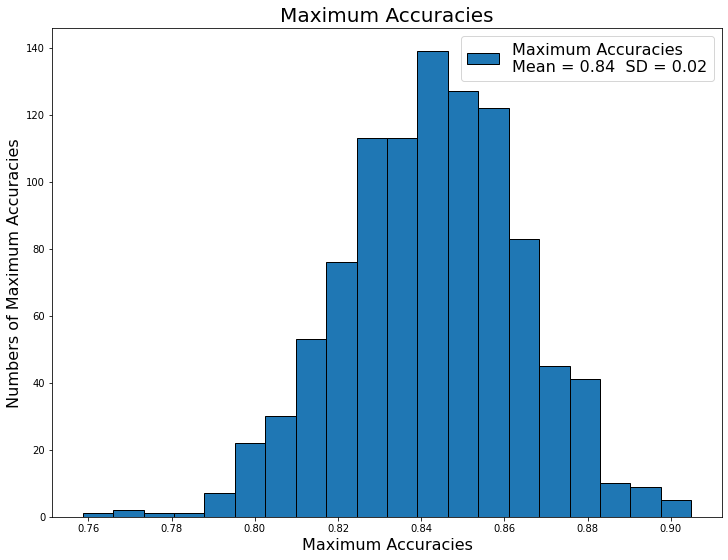

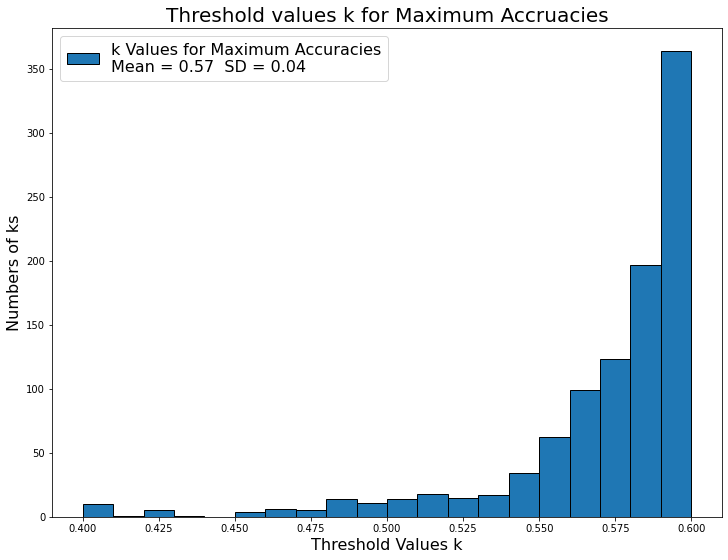

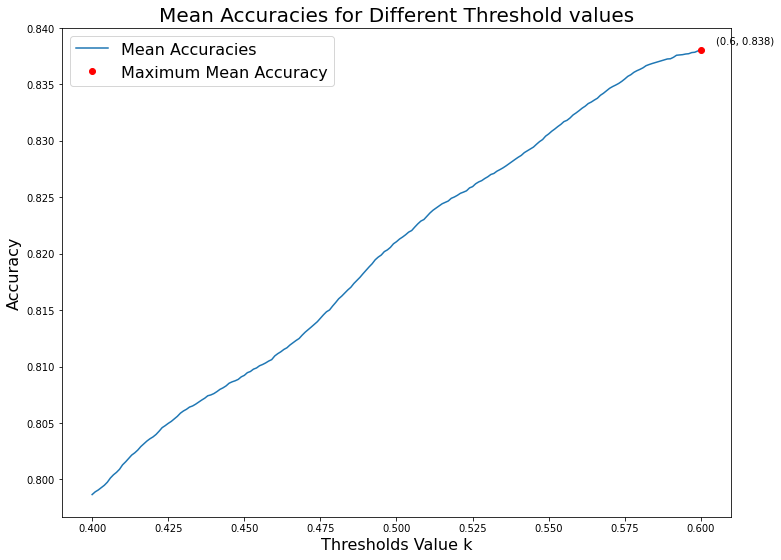

Logistic Regression with zScaling:
Averages for all examples 1000 trials with k=0.5
 Mean weight of C1 = 1.067, 95% confidence interval = 0.108
 Mean weight of C2 = -0.067, 95% confidence interval = 0.097
 Mean weight of C3 = -0.999, 95% confidence interval = 0.107
 Mean weight of age = -2.037, 95% confidence interval = 0.355
 Mean weight of male gender = -2.399, 95% confidence interval = 0.149
 Mean accuracy = 0.821, 95% confidence interval = 0.045
 Mean sensitivity = 0.803, 95% confidence interval = 0.065
 Mean specificity = 0.841, 95% confidence interval = 0.065
 Mean pos. pred. val. = 0.841, 95% confidence interval = 0.065
 Mean AUROC = 0.838, 95% confidence interval = 0.053


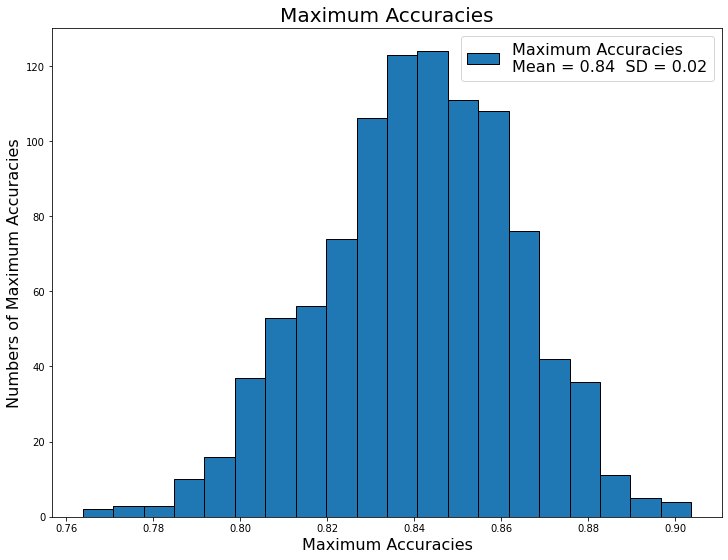

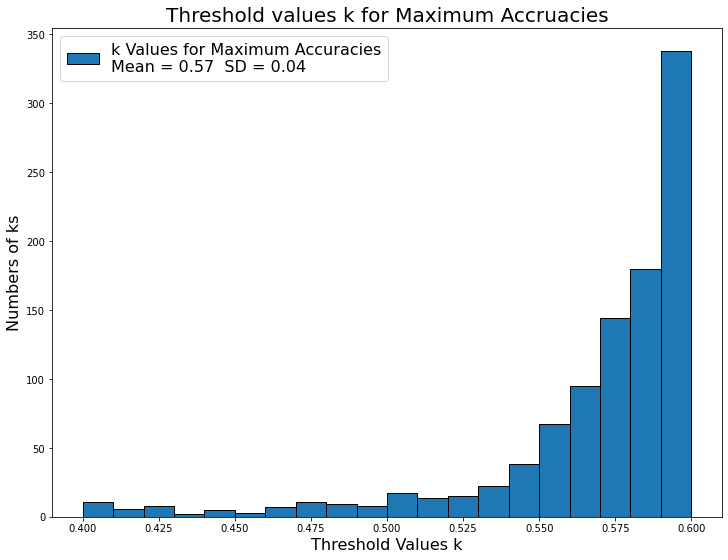

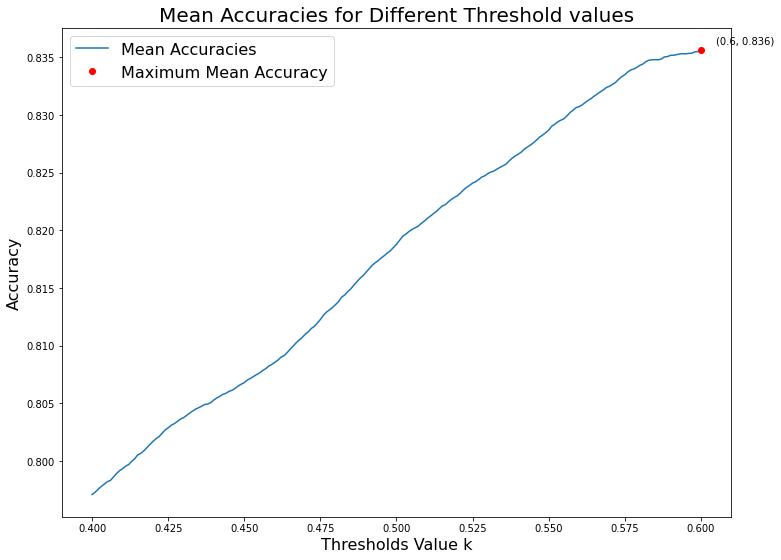

Logistic Regression with iScaling:
Averages for all examples 1000 trials with k=0.5
 Mean weight of C1 = 1.069, 95% confidence interval = 0.108
 Mean weight of C2 = -0.067, 95% confidence interval = 0.103
 Mean weight of C3 = -1.002, 95% confidence interval = 0.112
 Mean weight of age = -2.045, 95% confidence interval = 0.366
 Mean weight of male gender = -2.405, 95% confidence interval = 0.146
 Mean accuracy = 0.819, 95% confidence interval = 0.047
 Mean sensitivity = 0.8, 95% confidence interval = 0.068
 Mean specificity = 0.84, 95% confidence interval = 0.066
 Mean pos. pred. val. = 0.84, 95% confidence interval = 0.066
 Mean AUROC = 0.836, 95% confidence interval = 0.052


In [25]:
examples = buildExamples('TitanicPassengers.txt')
z_scaling_examples, i_scaling_examples = list(examples), list(examples)
feature_age = []
for e in examples:
    feature_age.append(e.getAge())
z_scaling_age = zScaleFeatures(feature_age)
i_scaling_age = iScaleFeatures(feature_age)
for i in range(len(z_scaling_examples)):
    z_scaling_examples[i].featureVec[3] = z_scaling_age[i]
    i_scaling_examples[i].featureVec[3] = i_scaling_age[i]

testModel(z_scaling_examples, 1000, title1='Logistic Regression with zScaling:',
          title2='Averages for all examples 1000 trials with k=0.5')
print('='*100)
testModel(i_scaling_examples, 1000, title1='Logistic Regression with iScaling:',
          title2='Averages for all examples 1000 trials with k=0.5')
print('='*100)


### Part 5

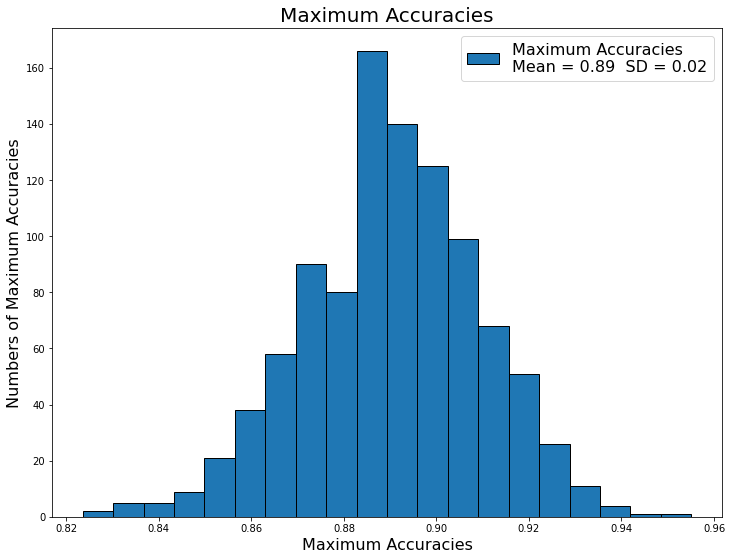

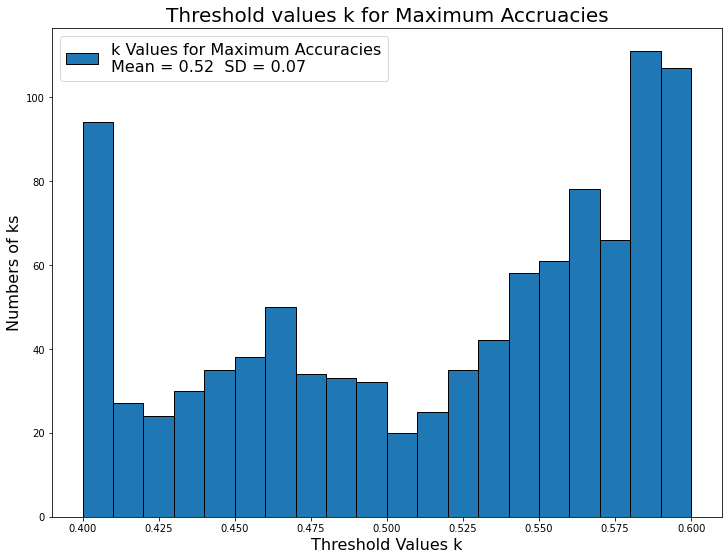

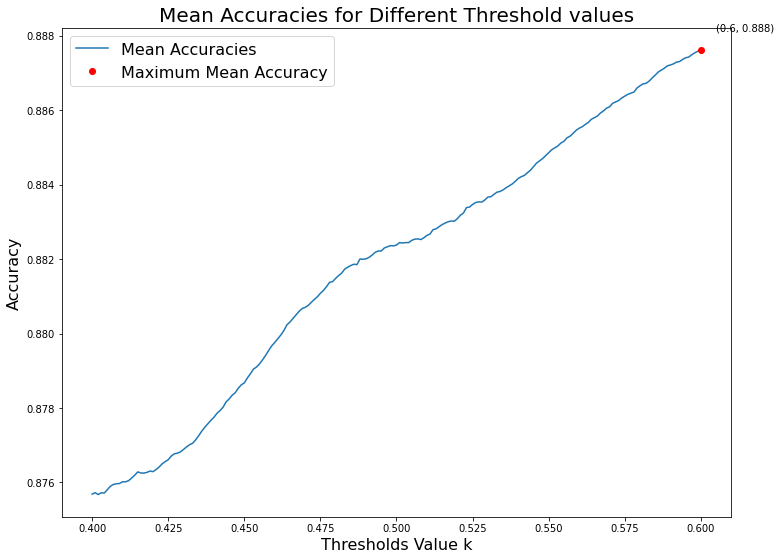

Logistic Regression with Male and Female Separated:
Averages for Male Examples 1000 trials with k=0.5
 Mean weight of C1 = 1.103, 95% confidence interval = 0.162
 Mean weight of C2 = -0.535, 95% confidence interval = 0.156
 Mean weight of C3 = -0.556, 95% confidence interval = 0.14
 Mean weight of age = -0.047, 95% confidence interval = 0.009
 Mean weight of male gender = 0.011, 95% confidence interval = 0.055
 Mean accuracy = 0.882, 95% confidence interval = 0.039
 Mean sensitivity = 0.805, 95% confidence interval = 0.065
 Mean specificity = 0.978, 95% confidence interval = 0.033
 Mean pos. pred. val. = 0.978, 95% confidence interval = 0.033
 Mean AUROC = 0.686, 95% confidence interval = 0.105


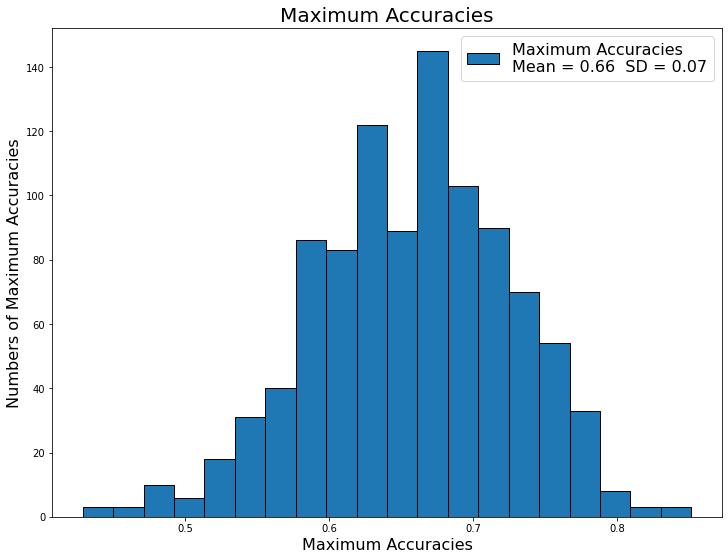

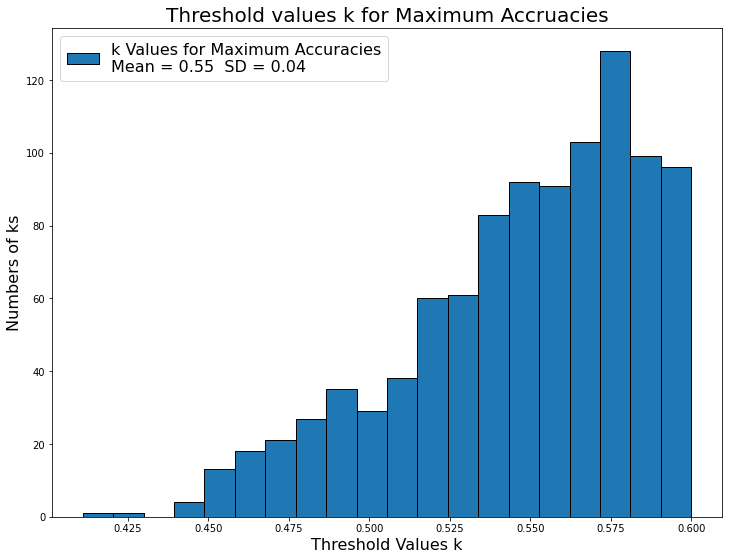

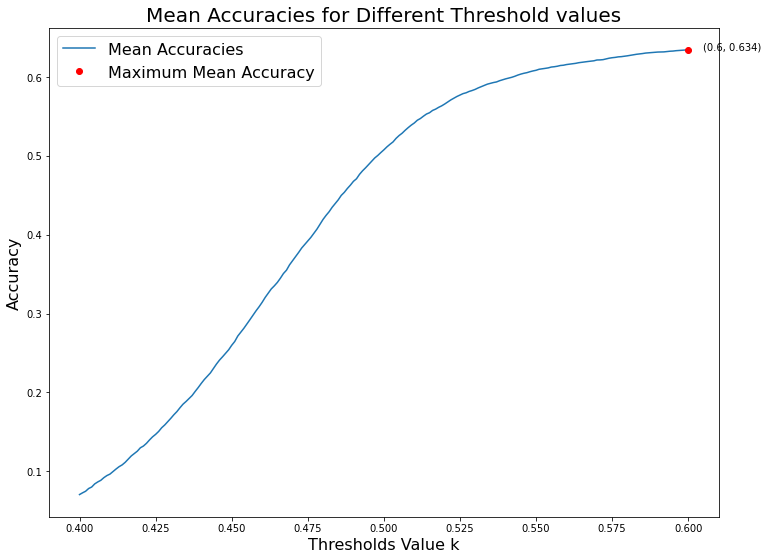

Averages for Female Examples 1000 trials with k=0.5
 Mean weight of C1 = 1.416, 95% confidence interval = 0.249
 Mean weight of C2 = 0.405, 95% confidence interval = 0.212
 Mean weight of C3 = -1.821, 95% confidence interval = 0.192
 Mean weight of age = -0.015, 95% confidence interval = 0.011
 Mean weight of male gender = 0.0, 95% confidence interval = 0.0
 Mean accuracy = 0.508, 95% confidence interval = 0.2
 Mean sensitivity = nan, 95% confidence interval = nan
 Mean specificity = 0.52, 95% confidence interval = 0.337
 Mean pos. pred. val. = 0.52, 95% confidence interval = 0.337
 Mean AUROC = 0.828, 95% confidence interval = 0.092


In [26]:
examples = buildExamples('TitanicPassengers.txt')
male_examples, female_examples = [], []
for e in examples:
    if e.getGender() == 1:
        male_examples.append(e)
    else:
        female_examples.append(e)

testModel(male_examples, 1000, title1='Logistic Regression with Male and Female Separated:',
          title2='Averages for Male Examples 1000 trials with k=0.5')
print('='*100)
testModel(female_examples, 1000, title2='Averages for Female Examples 1000 trials with k=0.5')
print('='*100)


## Part 6, 7

### Part 6

In [27]:
examples = buildExamples('TitanicPassengers.txt')
training, testSet = divide80_20(examples)
minK = 1
maxK = 25
nfold = 10
n_fold_accuracies, most_acc_k, most_acc = findK(training, minK, maxK, nfold, label=1)


k-NN Prediction for Survive with k=3:
TP, FP, TN, FN = 57, 21, 105, 26
                      TP     FP
Confusion Matrix is:  57     21
                     105     26
                      TN     FN
 Accuracy = 0.775
 Sensitivity = 0.687
 Specificity = 0.833
 Pos. Pred. Val. = 0.731
k-NN Prediction for Survive with k=4:
TP, FP, TN, FN = 45, 15, 111, 38
                      TP     FP
Confusion Matrix is:  45     15
                     111     38
                      TN     FN
 Accuracy = 0.746
 Sensitivity = 0.542
 Specificity = 0.881
 Pos. Pred. Val. = 0.75
Predictions with maximum accuracy k: 4
Cross Validation Accuracies is: 0.7464114832535885
Predicted Accuracies is: 0.7383233532934131


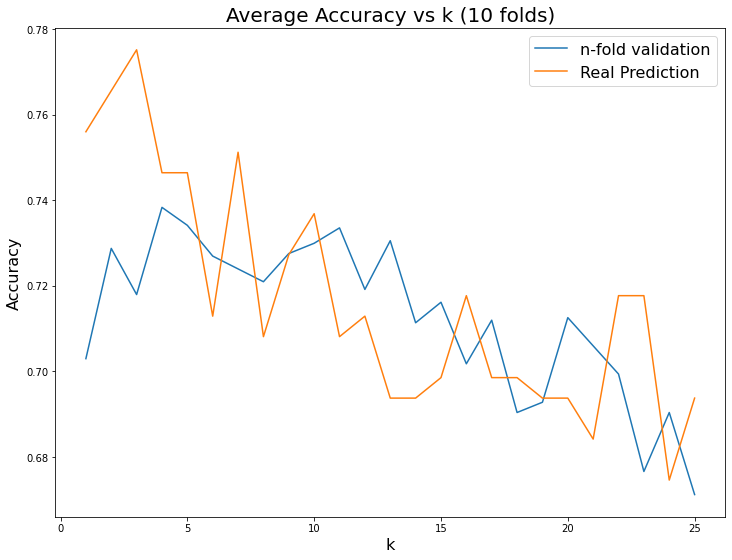

In [28]:
cross_accu = []
for i in range(minK, maxK+1):
    truePos, falsePos, trueNeg, falseNeg = KNearestClassify(training, testSet, 1, i)
    cross_accu.append(accuracy(truePos, falsePos, trueNeg, falseNeg))
for i in (3, most_acc_k):
    print(f'k-NN Prediction for Survive with k={i}:')
    truePos, falsePos, trueNeg, falseNeg = KNearestClassify(training, testSet, 1, i)
    print(f'TP, FP, TN, FN = {truePos}, {falsePos}, {trueNeg}, {falseNeg}')
    print('                      TP     FP')
    print(f'Confusion Matrix is: {truePos:3d}    {falsePos:3d}')
    print(f'                     {trueNeg:3d}    {falseNeg:3d}')
    print('                      TN     FN')
    getStats(truePos, falsePos, trueNeg, falseNeg)
    print('='*50)
    
print(f'Predictions with maximum accuracy k: {most_acc_k}')
print('Cross Validation Accuracies is: {}'.format(cross_accu[most_acc_k-1]))
print(f'Predicted Accuracies is: {most_acc}')
pylab.figure(facecolor='white', figsize=(12, 9))
pylab.plot(range(minK, maxK+1), n_fold_accuracies, label='n-fold validation')
pylab.plot(range(minK, maxK+1), cross_accu, label='Real Prediction')
pylab.title(f'Average Accuracy vs k ({nfold} folds)', fontsize=20)
pylab.xlabel('k', fontsize=16)
pylab.ylabel('Accuracy', fontsize=16) 
pylab.legend(fontsize=16)
pylab.show()
print('='*100)


### Part 7

In [29]:
male_examples, female_examples = [], []
for d in examples:
    if d.getGender() == 1:
        male_examples.append(d)
    else:
        female_examples.append(d)
male_training, male_testSet = divide80_20(male_examples)
female_training, female_testSet = divide80_20(female_examples)


In [30]:
print('For male:')
male_TP, male_FP, male_TN, male_FN = KNearestClassify(male_training, male_testSet, 1, 3)
print(f'TP, FP, TN, FN = {male_TN}, {male_FN}, {male_TN}, {male_FN}')
print('                      TP     FP')
print(f'Confusion Matrix is: {male_TP:3d}    {male_FP:3d}')
print(f'                     {male_TN:3d}    {male_FN:3d}')
print('                      TN     FN')
getStats(male_TP, male_FP, male_TN, male_FN)
print('='*50)

print('For female:')
female_TP, female_FP, female_TN, female_FN = KNearestClassify(female_training, female_testSet, 1, 3)
print(f'TP, FP, TN, FN = {female_TN}, {female_FN}, {female_TN}, {female_FN}')
print('                      TP     FP')
print(f'Confusion Matrix is: {female_TP:3d}    {female_FP:3d}')
print(f'                     {female_TN:3d}    {female_FN:3d}')
print('                      TN     FN')
getStats(female_TP, female_FP, female_TN, female_FN)
print('='*100)

print('Combined Predictions Statistics:')
TP = male_TP + female_TP
FP = male_FP + female_FP
TN = male_TN + female_TN
FN = male_FN + female_FN
print(f'TP, FP, TN, FN = {TN}, {FN}, {TN}, {FN}')
print('                      TP     FP')
print(f'Confusion Matrix is: {TP:3d}    {FP:3d}')
print(f'                     {TN:3d}    {FN:3d}')
print('                      TN     FN')
getStats(TP, FP, TN, FN)
print('='*100)


For male:
TP, FP, TN, FN = 98, 20, 98, 20
                      TP     FP
Confusion Matrix is:   7      6
                      98     20
                      TN     FN
 Accuracy = 0.802
 Sensitivity = 0.259
 Specificity = 0.942
 Pos. Pred. Val. = 0.538
For female:
TP, FP, TN, FN = 8, 5, 8, 5
                      TP     FP
Confusion Matrix is:  55      9
                       8      5
                      TN     FN
 Accuracy = 0.818
 Sensitivity = 0.917
 Specificity = 0.471
 Pos. Pred. Val. = 0.859
Combined Predictions Statistics:
TP, FP, TN, FN = 106, 25, 106, 25
                      TP     FP
Confusion Matrix is:  62     15
                     106     25
                      TN     FN
 Accuracy = 0.808
 Sensitivity = 0.713
 Specificity = 0.876
 Pos. Pred. Val. = 0.805
